### Importing prerequisite libraries

In [1]:
# !pip install dowhy econml
from tqdm import tqdm

import dowhy
import pandas as pd

pd.options.display.max_columns = 100

In [2]:
# Avoiding unnecessary log messages and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

### Data Description

In [3]:
data_type_map = {
    'decision_date' : 'str',
    'filing_date' : 'str',
    'Court Name' : 'category',
    'Party of Appointing President' : 'category',
    'CIRCUIT' : 'category',
    'JURIS' : 'category',
    'NOS' : 'category',
    'ORIGIN' : 'category',
    'RESIDENC' : 'category',
    'CLASSACT' : 'category',
    'DEMANDED' : 'float64',
    'TERMDATE' : 'str',
    'DISP' : 'category',
    'PROCPROG' : 'category',
    'NOJ' : 'category',
    'AMTREC' : 'category',
    'JUDGMENT' : 'int',
    'TAPEYEAR' : 'float64',
    'district' : 'category',
    'office' : 'category',
    'county' : 'category',
    'TRCLACT' : 'category',
    'PROSE' : 'category',
    'arbit' : 'category',
    'transoff' : 'category',
    'trmarb' : 'category',
    'ifp' : 'category',
    'statuscd' : 'category'
}

columns_to_drop = [
    'decision_date',
#     'filing_date',
    'TERMDATE',
    'TAPEYEAR'
]

file_path = '/scratch/ayl316/ttml_mr_data/processed_data_2/new_cases.csv.zip'
# file_path = '/scratch/ayl316/ttml_mr_data/processed_data/cases.csv.zip'
df = pd.read_csv(file_path, 
                    dtype = data_type_map, 
                    parse_dates = ['decision_date', 'filing_date', 'TERMDATE']
      ).rename(columns = {
                'Court Name' : 'court_name',
                'Party of Appointing President' : 'party'
      }).drop(columns = columns_to_drop)

df['filing_year'] = pd.DatetimeIndex(df['filing_date']).year
df['filing_year'] = df['filing_year'].astype(str).astype('category')
df = df.drop(columns = ['filing_date'])

for col in ['party', 'TRCLACT', 'PROSE', 'arbit', 'transoff', 'trmarb', 'ifp', 'statuscd', 'filing_year']:
    if not '-8' in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('-8')
    df[col] = df[col].fillna('-8')

df['district_year'] = df['district'].astype(str) + '_' + df['filing_year'].astype(str)

### Feature Engineering

In [4]:
df = df[~df.party.isnull() & (df.party == 'Republican') | (df.party == 'Democratic')]
df = df[~df.JUDGMENT.isnull() & (df.JUDGMENT == 1) | (df.JUDGMENT == 2)]
df['is_dem'] = (df.party == 'Democratic') * 1
df.drop('party', axis=1, inplace=True)
df.shape

In [5]:
df.head()

,court_name,CIRCUIT,JURIS,NOS,ORIGIN,RESIDENC,CLASSACT,DEMANDED,DISP,PROCPROG,NOJ,AMTREC,JUDGMENT,district,office,county,TRCLACT,PROSE,arbit,transoff,trmarb,ifp,statuscd,filing_year,district_year,is_dem
0,U.S. District Court for the District of Rhode ...,9.0,4.0,367.0,1.0,25.0,-8.0,0.0,6.0,5.0,0.0,0.0,2,74,3,88888,-8.0,0.0,-8,-8.0,-8,-8,L,2015.0,74_2015.0,0
1,U.S. District Court for the District of Rhode ...,9.0,4.0,367.0,1.0,25.0,-8.0,0.0,6.0,5.0,0.0,0.0,2,74,3,88888,-8.0,0.0,-8,-8.0,-8,-8,L,2015.0,74_2015.0,0
2,U.S. District Court for the District of Rhode ...,9.0,4.0,367.0,1.0,25.0,-8.0,0.0,6.0,5.0,0.0,0.0,2,74,3,88888,-8.0,0.0,-8,-8.0,-8,-8,L,2015.0,74_2015.0,0
3,U.S. District Court for the District of Rhode ...,9.0,4.0,367.0,1.0,25.0,-8.0,0.0,6.0,5.0,0.0,0.0,2,74,3,88888,-8.0,0.0,-8,-8.0,-8,-8,L,2015.0,74_2015.0,0
4,U.S. District Court for the District of Rhode ...,9.0,4.0,367.0,1.0,25.0,-8.0,0.0,6.0,5.0,0.0,0.0,2,74,3,88888,-8.0,0.0,-8,-8.0,-8,-8,L,2015.0,74_2015.0,0


In [6]:
counts_sum=0
for i in tqdm(range(10000)):
    counts_i = 0
    rdf = df.sample(1000)
    counts_i = rdf[(rdf["is_dem"]==rdf["JUDGMENT"])].shape[0]
    counts_sum += counts_i
counts_sum/10000

100%|██████████| 10000/10000 [03:06<00:00, 53.53it/s]


In [7]:
df.groupby(['is_dem', 'JUDGMENT']).count()['court_name'].unstack()

JUDGMENT,1,2
is_dem,,
0,86079,382894
1,68964,283082


### Creating a causal graph

In [8]:
# import pygraphviz
causal_graph = """digraph {
U[label="Unobserved Confounders"];
CIRCUIT;
JURIS;
NOS;
ORIGIN;
RESIDENC;
CLASSACT;
DEMANDED;
DISP;
PROCPROG;
NOJ;
AMTREC;
JUDGMENT;
district;
office;
county;
TRCLACT;
PROSE;
arbit;
transoff;
trmarb;
ifp;
statuscd;
filing_year;
district_year;
is_dem;
U->is_dem;U->JUDGMENT;
DISTRICT->CIRCUIT;
JURIS->DISTRICT;
NOS->JUDGMENT;
CLASSACT->TRCLACT
}"""

### Modeling

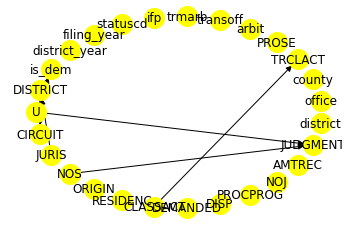

In [19]:
treatment = 'is_dem'
outcome = 'JUDGMENT'

df = df.sample(10000)
model = dowhy.CausalModel(df, treatment=treatment, outcome=outcome, graph=causal_graph.replace('\n', ' '))
model.view_model(layout='dot')
# from IPython.display import Image, display
# display(Image(filename="causal_model.png"))

### Identifying the Causal Effect

In [21]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
─────────(Expectation(JUDGMENT|DEMANDED,transoff,NOS,office,arbit,TRCLACT,coun
d[is_dem]                                                                     

                                                                              
ty,PROCPROG,trmarb,CIRCUIT,ORIGIN,JURIS,ifp,district_year,RESIDENC,CLASSACT,DI
                                                                              

                                                   
SP,filing_year,NOJ,AMTREC,district,statuscd,PROSE))
                                                   
Estimand assumption 1, Unconfoundedness: If U→{is_dem} and U→JUDGMENT then P(JUDGMENT|is_dem,DEMANDED,transoff,NOS,office,arbit,TRCLACT,county,PROCPROG,trmarb,CIRCUIT,ORIGIN,JURIS,ifp,district_year,RESIDENC,CLASSACT,DISP,filing_year,NOJ,AMTREC,district,statuscd,PROSE,U) =

### Estimate the identified estimand

In [22]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1)
print(linear_estimate)

ValueError: shapes (311,5060) and (6156,) not aligned: 5060 (dim 1) != 6156 (dim 0)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

### Refute Estimate

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=100 # at least 100 is good, setting to 10 for speed
        )
print(res_placebo)